# pandas 3

__자료 안내:__ 

1. [pandas 라이브러리 튜토리얼](https://pandas.pydata.org/pandas-docs/stable/tutorials.html)에 
있는 Lessons for new pandas users의 [03-Lesson](http://nbviewer.jupyter.org/urls/bitbucket.org/hrojas/learn-pandas/raw/master/lessons/03%20-%20Lesson.ipynb) 내용을 담고 있다.

1. 익명함수(`lambda` 함수), `GroupBy`, `apply`, `transform`에 대한 설명은 파이썬 튜토리얼, 
    pandas 튜토리얼과 한빛미디어의 <파이썬 라이브러리를 활용한 데이터 분석>책의 일부이다.

2. 사분위수에 관한 내용은 자유아카데미의 <통계학>책의 일부이다. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np

In [6]:
# 쥬피터 노트북에서 그래프를 직접 나타내기 위해 사용하는 코드
# 파이썬 전문 에디터에서는 사용하지 않음
%matplotlib inline

분석을 위한 테스트 데이터를 만들어 보자.

In [5]:
# seed 값을 111
np.seed(111)

# 테스트 데이터를 생성하는 함수 정의
def CreateDataSet(Number=1):
    
    Output = []
    
    for i in range(Number):
        
        # 2009년 1월 1일부터 2012년 12월 31일 사이에 있는 월요일에 해당하는 날짜를 생성
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        # rng의 길이와 같은 크기의 랜덤한 수에 대한 리스트 만들기
        # 이때, 랜덤수는 25와 1000 사이에 있는 정수
        data = np.randint(low=25,high=1000,size=len(rng))
        
        # Status에 대한 리스트 만들기
        status = [1,2,3]
        
        # rng의 길이와 같은 크기의 랜덤한 statuses 리스트 만들기
        random_status = [status[np.randint(low=0,high=len(status))] for i in range(len(rng))]
        
        # State에 대한 리스트 만들기 
        states = ['GA','FL','fl','NY','NJ','TX']
        
        # rng의 길이와 같은 크기의 랜덤한 states 리스트 만들기 
        random_states = [states[np.randint(low=0,high=len(states))] for i in range(len(rng))]
    
        Output.extend(zip(random_states, random_status, data, rng))
        
    return Output

위의 함수를 이용하여 테스트 데이터를 만들고, 이를 다시 데이터프레임으로 만들어보자.

In [6]:
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['State','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [7]:
df.head()

,State,Status,CustomerCount,StatusDate
0,GA,1,877,2009-01-05
1,FL,1,901,2009-01-12
2,fl,3,749,2009-01-19
3,FL,3,111,2009-01-26
4,GA,1,300,2009-02-02


위의 데이터프레임을 Excel 파일로 저장하자. 이 때 인덱스 값은 원래의 테스트 데이터셋의 일부가 아니기 때문에 저장하지 않는다. 

In [8]:
df.to_excel('Lesson3.xlsx', index=False)
print('Done')

Done


## 1. Excel로부터 데이터 가져오기

`read_excel` 함수를 이용하여 Excel 파일을 읽을 수 있다. 이 함수는 특정한 이름 또는 위치의 탭(tab)을 읽을 수 있다.

In [9]:
# 파일의 위치
Location = 'Lesson3.xlsx'

# 아래의 코드에서 0은 첫번째 시트를 의미.
# index_col = 'StatusDate'는 StatusDate를 인덱스로 가져오라는 의미
df = pd.read_excel(Location, 0, index_col='StatusDate')
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [10]:
# 데이터프레임의 인덱스를 확인
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name='StatusDate', length=836, freq=None)

In [11]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-01-19,fl,3,749
2009-01-26,FL,3,111
2009-02-02,GA,1,300


## 2. 데이터 준비하기 

분석을 위해서 데이터에 다음과 같은 전처리를 해보자.

1) state 열의 값이 모두 대문자인지를 확인

2) status 값이 1인 레코드만 선택

3) state열에서 NJ를 NY으로 변경

4) 이상치 제거

1) state 열의 값이 모두 대문자인지를 확인

: State 열의 값이 대문자인지, 소문자인지를 빠르게 확인해 보자.

In [12]:
df['State'].unique()

array(['GA', 'FL', 'fl', 'TX', 'NY', 'NJ'], dtype=object)

State 열의 값을 모두 대문자로 변경하기 위해서 `upper()` 함수와 데이터프레임의 `apply`을 이용한다. `apply` 메소드를 통해서 각 로우(row)나 칼럼(column)의 1차원 배열에 함수를 적용할 수 있다. 그리고 `lambda`함수는 간단하게 State 열의 각 값을 대문자로 변경하도록 해준다.

먼저 `lambda` 함수에 대해서 간단히 알아보자.

[익명 함수 또는 `lambda` 함수]

파이썬은 익명 함수 또는 lambda 함수라고 하는, 값을 반환하는 단순한 한 문장으로 이루어진 함수를 지원한다. 람다 함수는 데이터 분석에서 특히 편리한데, 이는 람다 함수를 사용하면 코드를 적게 쓰며, 코드도 더 간결해지기 때문이다.

In [13]:
# 람다 함수는 아래와 같이 사용
# lambda arguments : expression 
# 예를 들어, 아래의 코드는 두 개의 argument의 합을 리턴

x = lambda a, b : a + b
x(3, 5)

8

이제 State 열의 값을 대문자로 변경해 보자.

In [14]:
# State 열의 값을 대문자로 변경
df['State'] = df.State.apply(lambda x: x.upper())

In [15]:
df['State'].unique()

array(['GA', 'FL', 'TX', 'NY', 'NJ'], dtype=object)

2) status 값이 1인 레코드만 선택

In [16]:
# Only grab where Status == 1
mask = df['Status'] == 1
df = df[mask]

3) state열에서 NJ를 NY으로 변경

`[df.State == 'NJ']` - State 열의 값이 NJ 인 모든 레코드를 찾기

`df.State[df.State == 'NJ'] = 'NY'` - State 열의 값이 NJ인 모든 레코드의 NJ를 NY으로 변경.

In [17]:
mask = df.State == 'NJ'
df['State'][mask] = 'NY'

이제 정리된 데이터의 State의 열의 유일한 값들을 확인해 보자.

In [18]:
df['State'].unique()

array(['GA', 'FL', 'NY', 'TX'], dtype=object)

4) 이상치 제거

본 절에서는 데이터프레임을 `State`와 `StatusDate`의 연도를 기준으로 그룹을 분리한 후, 각 그룹에 있는 `CustomeCount`에 대해서 사분위수를 이용하여 이상치 제거를 하려고 한다.

먼저 GroupBy과 `apply`, `transform` 메소드를 간단하게 살펴보자.

[GroupBy]

pandas는 데이터셋을 자연스럽게 나누고 요약할 수 있는 `groupby`라는 유연한 방법을 제공한다. 
그룹연산(분리-적용-결합)의 첫 번째 단계는 데이터프레임에 들어있는 데이터를 하나 이상의 색인을 기준으로 분리한다. 예를 들어, 데이터프레임은 로우(`axis = 0`)로 분리하거나 칼럼(`axis = 1`)로 분리할 수 있다. 분리하고 나면 함수를 각 그룹에 적용시켜 새로운 값을 얻어낸다. 그리고 마지막으로 함수를 적용한 결과를 하나의 객체로 결합한다.

[그림 9-1]은 그룹 연산의 예시이다.

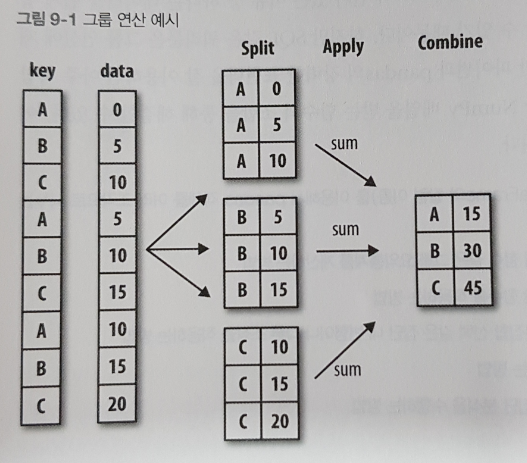

In [19]:
from IPython.display import Image
Image("python_for_data_analysis_p346.png")

실제로 데이터프레임을 만들어 그룹 연산을 시행해 보자.

In [20]:
dftest = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C' ], 'data' : [0, 5, 10, 5, 10, 15, 10, 15, 20]})
dftest

,key,data
0,A,0
1,B,5
2,C,10
3,A,5
4,B,10
5,C,15
6,A,10
7,B,15
8,C,20


In [21]:
# key라는 열에 대해서 그룹으로 분리하고, 각 그룹에 sum()를 적용
dftest.groupby('key').sum()

,data
key,
A,15
B,30
C,45


 [`apply` 과 `transform`]
 
 위에서 생성한 데이터프레임 `dftest`에 `apply`와 `transform` 메소드로 그룹 연산을 수행해보자.

In [22]:
dftest.groupby('key')['data'].apply(lambda x : x.sum())

key
A    15
B    30
C    45
Name: data, dtype: int64

In [23]:
dftest.groupby('key')['data'].transform(lambda x : x.sum())

0    15
1    30
2    45
3    15
4    30
5    45
6    15
7    30
8    45
Name: data, dtype: int64

`apply`의 결과는 병합된 것을 볼 수 있는 반면 `transform` 메소드는 데이터프레임의 크기를 유지하는 것을 볼 수 있다.

이제 `State`와 `StatusDate`를 기준으로 `CustomerCount` 값을 합해보자. 이때, 데이터프레임 `df`에는 `StatusDate`가 index이므로 `StatusDate`를 기준으로 그룹화하기 위해서 이를 일반열로 보내야 한다. 이를 위해 `reset_index()`를 이용한다. 

In [24]:
df.reset_index().head()

,StatusDate,State,Status,CustomerCount
0,2009-01-05,GA,1,877
1,2009-01-12,FL,1,901
2,2009-02-02,GA,1,300
3,2009-03-09,NY,1,992
4,2009-04-06,FL,1,291


In [25]:
Daily = df.reset_index().groupby(['State','StatusDate']).sum()
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-12       1            901
      2009-02-02       1            653
      2009-03-23       1            752
      2009-04-06       2           1086
      2009-06-08       1            649

`Status`의 값은 필요가 없으므로, 아래와 같이 삭제한다.

In [26]:
del Daily['Status']
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-12            901
      2009-02-02            653
      2009-03-23            752
      2009-04-06           1086
      2009-06-08            649

데이터프레임 `Daily`의 인덱스를 확인해 보자.

In [27]:
Daily.index

MultiIndex(levels=[['FL', 'GA', 'NY', 'TX'], [2009-01-05 00:00:00, 2009-01-12 00:00:00, 2009-01-19 00:00:00, 2009-02-02 00:00:00, 2009-02-23 00:00:00, 2009-03-09 00:00:00, 2009-03-16 00:00:00, 2009-03-23 00:00:00, 2009-03-30 00:00:00, 2009-04-06 00:00:00, 2009-04-13 00:00:00, 2009-04-20 00:00:00, 2009-04-27 00:00:00, 2009-05-04 00:00:00, 2009-05-11 00:00:00, 2009-05-18 00:00:00, 2009-05-25 00:00:00, 2009-06-08 00:00:00, 2009-06-22 00:00:00, 2009-07-06 00:00:00, 2009-07-13 00:00:00, 2009-07-20 00:00:00, 2009-07-27 00:00:00, 2009-08-10 00:00:00, 2009-08-17 00:00:00, 2009-08-24 00:00:00, 2009-08-31 00:00:00, 2009-09-07 00:00:00, 2009-09-14 00:00:00, 2009-09-21 00:00:00, 2009-09-28 00:00:00, 2009-10-05 00:00:00, 2009-10-12 00:00:00, 2009-10-19 00:00:00, 2009-10-26 00:00:00, 2009-11-02 00:00:00, 2009-11-23 00:00:00, 2009-11-30 00:00:00, 2009-12-07 00:00:00, 2009-12-14 00:00:00, 2010-01-04 00:00:00, 2010-01-11 00:00:00, 2010-01-18 00:00:00, 2010-01-25 00:00:00, 2010-02-08 00:00:00, 2010-02-1

다음과 같이 각각의 인덱스도 확인할 수 있다.

In [28]:
# State 인덱스 확인
Daily.index.levels[0]

Index(['FL', 'GA', 'NY', 'TX'], dtype='object', name='State')

In [29]:
# StatusDate 인덱스 확인
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-02-02',
               '2009-02-23', '2009-03-09', '2009-03-16', '2009-03-23',
               '2009-03-30', '2009-04-06',
               ...
               '2012-09-24', '2012-10-01', '2012-10-08', '2012-10-22',
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-10'],
              dtype='datetime64[ns]', name='StatusDate', length=161, freq=None)

이제 데이터프레임을 State와 StatusDate의 연도를 기준으로 그룹을 분리해 보자.

In [30]:
StateYear = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year])

`StateYear`의 각 그룹에 있는 CustomerCount에 대해서 사분위수를 이용하여 이상치를 제거를 시행해 보고자 한다. 이를 위해 먼저 사분위수를 이용하여 이상치를 제거하는 방법에 대해서 간단하게 살펴보자.

[사분위수를 이용하여 이상치를 제거하는 방법]


(a) 사분위수

전체 관측값을 작은 순서로 배열하였을 때, 사분위수는 전체를 사등분하는 값이다. 전체의 사분의 1, 사분의 2, 사분의 3은 각각 전체의 25%, 50%, 75%이고, 이를 제 1사분위수(Q1), 제 2사분위수(Q2) = 중앙값, 제 3사분위수(Q3)라고 한다.


(c) 사분위수 범위

제 3 사분위수와 제 1사분위수 사이의 거리를 퍼진 정도의 측도로 사용할 수 있는데, 이를 사분위수 범위(IQR)이라고 한다. 즉, IQR = 제 3사분위수 - 제 1사분위수 = Q3 - Q1


(d) 사분위수를 이용하여 이상치를 제거하는 방법

관측값이 Q1 - 1.5 IQR 보다 작거나 Q3 + 1.5 IQR 보다 크면, 이 값을 이상치라고 한다. 

예제로 살펴보자.

In [31]:
dftest1 = pd.DataFrame({'A' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]})
dftest1

,A
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [32]:
# A 열의 값에 대한 제 1사분위수는 3.5
Q1 = dftest1.quantile(q = 0.25)
Q1

A    3.5
Name: 0.25, dtype: float64

In [33]:
# A 열의 값에 대한 제 2사분위수는 5.5
Q2 = dftest1.quantile(q = 0.5)
Q2

A    6.0
Name: 0.5, dtype: float64

In [34]:
# A 열의 값에 대한 제 3사분위수는 8.5
Q3 = dftest1.quantile(q = 0.75)
Q3

A    8.5
Name: 0.75, dtype: float64

In [35]:
#  Lower = Q1 - 1.5 IQR
Lower = Q1 - 1.5*(Q3 - Q1)
Lower

A   -4.0
dtype: float64

In [36]:
# Upper = Q3 + 1.5 IQR
Upper = Q3 + 1.5*(Q3 - Q1)
Upper

A    16.0
dtype: float64

`dftest1`의 A열의 자료 중 100은 `Upper`보다 크므로 이상치라고 할 수 있다.  

이제 StateYear의 각 그룹에 있는 CustomerCount에 대해서 사분위수를 이용하여 이상치를 제거 해보자. 

In [37]:
Daily['Lower'] = StateYear['CustomerCount'].transform( lambda x: x.quantile(q=.25) - 1.5*(x.quantile(q=.75)-x.quantile(q=.25)))
Daily['Upper'] = StateYear['CustomerCount'].transform( lambda x: x.quantile(q=.75) + 1.5*(x.quantile(q=.75)-x.quantile(q=.25)))
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

In [42]:
# 이상치를 제거해 보자.
Daily = Daily[Daily['Outlier'] == False]
Daily.head()

CustomerCount  Lower   Upper  Outlier
State StatusDate                                       
FL    2009-01-12            901  117.0  1133.0    False
      2009-02-02            653  117.0  1133.0    False
      2009-03-23            752  117.0  1133.0    False
      2009-04-06           1086  117.0  1133.0    False
      2009-06-08            649  117.0  1133.0    False